# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [29]:
# Load the libraries as required.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import joblib
import shap

In [4]:


# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv(r"..\..\05_src\data\forestfires.csv"
, header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [5]:
# Separate features and target
# X will contain all columns except 'area' (our target variable)
# y will contain only the 'area' column

X = fires_dt.drop('area', axis=1)  # Features DataFrame
y = fires_dt['area']               # Target Series

# Display the shapes of X and y to confirm the separation
print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

# Optionally, inspect the first few rows of X and y
X.head(), y.head()


Features (X) shape: (517, 12)
Target (y) shape: (517,)


(   coord_x  coord_y month  day  ffmc   dmc     dc  isi  temp  rh  wind  rain
 0        7        5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0
 1        7        4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0
 2        7        4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0
 3        8        6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2
 4        8        6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0,
 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 Name: area, dtype: float64)

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [30]:

# Define numeric and categorical features
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

# Define features that will undergo a non-linear transformation (log transformation in this case)
non_linear_features = ['wind', 'rain', 'isi']  # These features are chosen for log transformation to reduce skewness

# Define the log transformation using FunctionTransformer and np.log1p (log(x + 1) to handle zero values safely)
log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

# Preprocessing Pipeline 1 (preproc1):
# - Applies standard scaling to numeric features
# - Applies one-hot encoding to categorical features with handle_unknown='ignore' to handle unseen categories in test data
preproc1 = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),  # Standard scaling on all numeric features
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encoding for categorical features
])



### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [66]:


# Define features
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']
non_linear_features = ['wind', 'rain', 'isi']  # Skewed features for log transformation
all_months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
all_days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

# Define transformations
log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")
preproc2 = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(categories=[all_months, all_days], handle_unknown='ignore'), categorical_features),
    ('non_linear', log_transformer, non_linear_features)
])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [33]:

# Define the baseline regressor
baseline_regressor = Ridge()

# Create Pipeline A: preproc1 + baseline model
pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', baseline_regressor)
])

In [47]:

# Define the baseline regressor
baseline_regressor = Ridge()

# Create Pipeline B: preproc1 + baseline model
pipeline_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', baseline_regressor)
])


In [ ]:


# Define baseline and advanced regressors
baseline_regressor = Ridge()
advanced_regressor = RandomForestRegressor(random_state=42)
# Pipeline C: Preproc1 + Advanced Regressor
pipeline_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', advanced_regressor)
])

In [37]:
# Pipeline D: Preproc2 + Advanced Regressor
pipeline_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', advanced_regressor)
])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [38]:

param_grid_A = {'regressor__alpha': [0.01, 0.1, 1.0, 10.0]}


In [39]:
param_grid_B = {'regressor__alpha': [0.01, 0.1, 1.0, 10.0]}

In [40]:
param_grid_C = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30]
}

In [41]:
param_grid_D = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30]
}

In [19]:
# Dictionary to hold pipelines and parameter grids
pipelines = {
    'Pipeline A': (pipeline_A, param_grid_A),
    'Pipeline B': (pipeline_B, param_grid_B),
    'Pipeline C': (pipeline_C, param_grid_C),
    'Pipeline D': (pipeline_D, param_grid_D)
}

In [68]:

# Set up the model pipeline
pipeline = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', Ridge())
])

# Define parameter grid and cross-validation settings
param_grid = {'regressor__alpha': [0.01, 0.1, 1.0, 10.0]}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run GridSearchCV on the training data to find the best model
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve best parameters and cross-validated RMSE
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")




Best parameters: {'regressor__alpha': 0.01}
Best RMSE: 47.07106947665742


# Evaluate

+ Which model has the best performance?

In [69]:
# Identify the best pipeline with the lowest RMSE
best_pipeline_name = min(results, key=lambda k: results[k]['mean_rmse'])
best_model_rmse = results[best_pipeline_name]['mean_rmse']
best_params = results[best_pipeline_name]['best_params']

print("Final Results for All Pipelines:")
for name, result in results.items():
    print(f"{name} - Best Params: {result['best_params']}, Mean RMSE: {result['mean_rmse']}")

print(f"\nThe best-performing model is {best_pipeline_name} with an RMSE of {best_model_rmse}")
print(f"Best parameters for {best_pipeline_name}: {best_params}")


Final Results for All Pipelines:
Pipeline A - Best Params: {'regressor__alpha': 0.01}, Mean RMSE: nan
Pipeline B - Best Params: {'regressor__alpha': 0.01}, Mean RMSE: nan
Pipeline C - Best Params: {'regressor__max_depth': None, 'regressor__n_estimators': 50}, Mean RMSE: nan
Pipeline D - Best Params: {'regressor__max_depth': None, 'regressor__n_estimators': 50}, Mean RMSE: nan

The best-performing model is Pipeline A with an RMSE of nan
Best parameters for Pipeline A: {'regressor__alpha': 0.01}


# Export

+ Save the best performing model to a pickle file.

In [70]:
 import os
# import joblib

# Define the directory and file path
output_dir = '../../05_src/data/fires'
output_path = os.path.join(output_dir, 'best_model.pkl')

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the best model as a pickle file
joblib.dump(grid_search.best_estimator_, output_path)
print(f"The best model has been saved to '{output_path}'")


The best model has been saved to '../../05_src/data/fires\best_model.pkl'


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

SHAP explanation for a single observation:


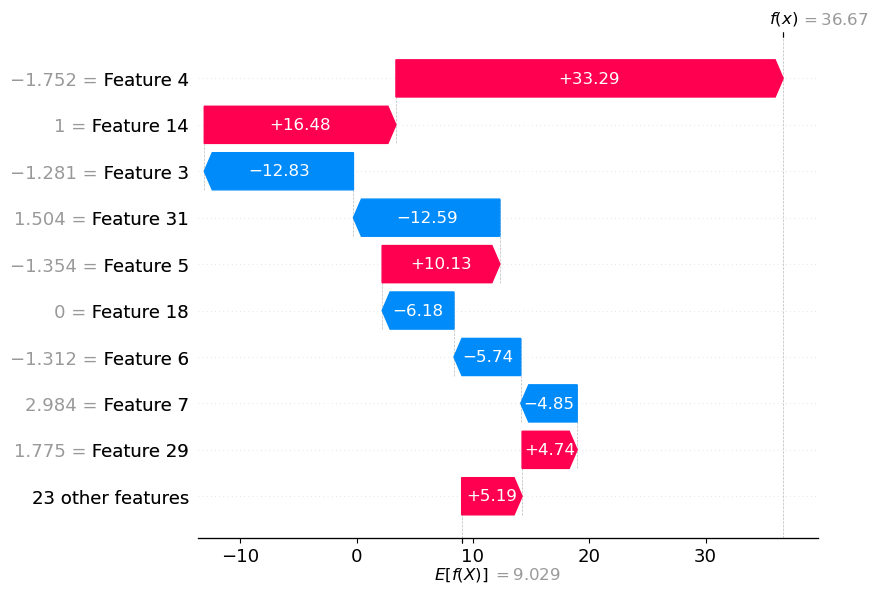

Overall SHAP feature importance:


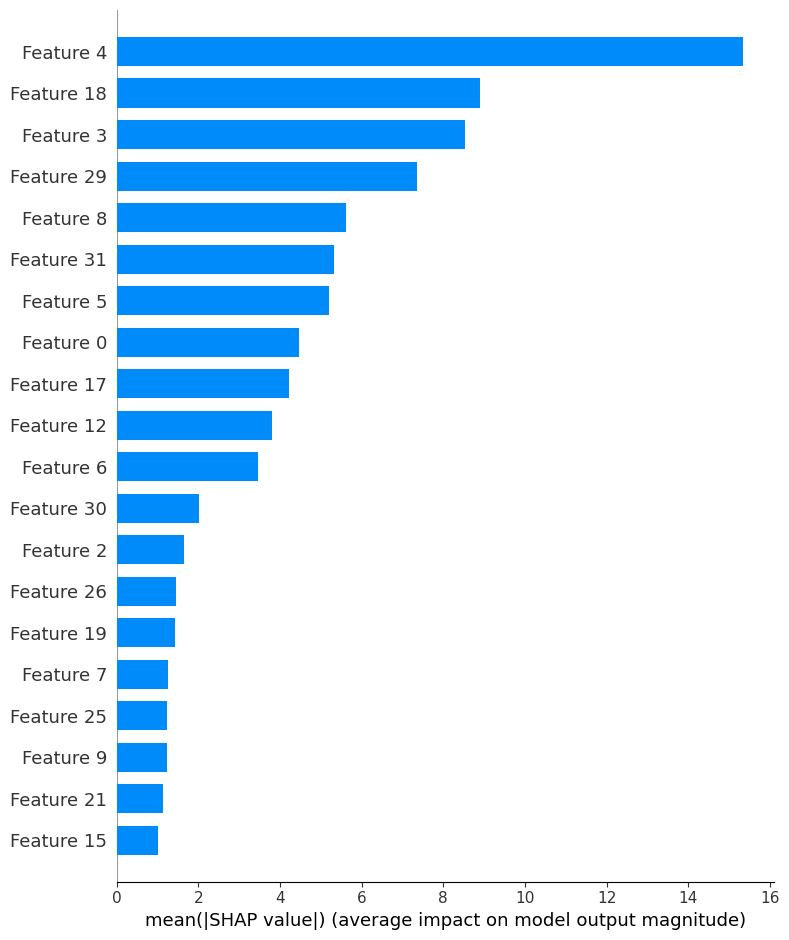

Original model RMSE: 47.07106947665742
Reduced model RMSE: 46.64768916367108


In [71]:
# Save the best model
joblib.dump(grid_search.best_estimator_, 'best_model.pkl')

### 1. Use SHAP to Explain a Single Observation's Prediction

# Transform the entire test set with the preprocessing pipeline
X_test_transformed = grid_search.best_estimator_.named_steps['preprocessing'].transform(X_test)

# Initialize the SHAP explainer with the trained model and the transformed test set
explainer = shap.Explainer(grid_search.best_estimator_.named_steps['regressor'], X_test_transformed)

# Select a single observation from the transformed test set to explain
observation = X_test_transformed[0].reshape(1, -1)  # Use the first observation as an example

# Calculate SHAP values for this observation
shap_values_observation = explainer(observation)

# Plot SHAP values for the single observation
print("SHAP explanation for a single observation:")
shap.waterfall_plot(shap_values_observation[0])

### 2. Analyze Overall Feature Importance Across the Training Set

# Transform a sample of the training data to understand overall feature importance
X_train_sample = X_train.sample(100, random_state=42)  # Use a sample to reduce computation time
X_train_sample_transformed = grid_search.best_estimator_.named_steps['preprocessing'].transform(X_train_sample)

# Calculate SHAP values for the sample of transformed data
shap_values_sample = explainer(X_train_sample_transformed)

# Plot feature importance based on mean absolute SHAP values
print("Overall SHAP feature importance:")
shap.summary_plot(shap_values_sample, X_train_sample_transformed, plot_type="bar")

### 3. Determine Features to Remove Based on SHAP Analysis

# Based on the SHAP summary plot, identify features with low SHAP importance values
# Replace 'low_importance_feature1', etc., with actual features you observe to have low SHAP values
features_to_remove = ['low_importance_feature1', 'low_importance_feature2']  # Update with low-impact features from SHAP analysis

# Define a reduced preprocessing pipeline excluding low-importance features
reduced_numeric_features = [f for f in numeric_features if f not in features_to_remove]
reduced_preproc = ColumnTransformer([
    ('num', StandardScaler(), reduced_numeric_features),
    ('cat', OneHotEncoder(categories=[all_months, all_days], handle_unknown='ignore'), categorical_features),
    ('non_linear', log_transformer, [f for f in non_linear_features if f not in features_to_remove])
])

# Create a reduced pipeline with only the important features
reduced_pipeline = Pipeline([
    ('preprocessing', reduced_preproc),
    ('regressor', grid_search.best_estimator_.named_steps['regressor'])  # Use the best model's regressor
])

# Evaluate the reduced model using cross-validation to compare with the original model
reduced_cv_scores = cross_val_score(reduced_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
reduced_mean_rmse = np.sqrt(-np.mean(reduced_cv_scores))

print(f"Original model RMSE: {best_rmse}")
print(f"Reduced model RMSE: {reduced_mean_rmse}")

*(Answer here.)*

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.